### ISC CamCan Suspense

The functional data were shared from the CAMCAN group (www.cam-can.org). The data were preprocessed and extracted from the 268 node Shen parcellation (not part of the scripts). Individual subjects' data are stored in a large dictionary for easier handling. The goal of this notebook is to run a simple 'static' ISC analysis (i.e. across the entire short movie and all participants) to map out which brain regions become aligned across the large audience during movie viewing.

### setting up modules

In [1]:
import os, sys, scipy, nilearn, warnings
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
import pandas as pd
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
from scipy import stats
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
%matplotlib inline

from camcan_utils import *

### seting up file paths

In [2]:
shen_atlas_filename   =  '../data/shen_2mm_268_parcellation.nii'
sample_file           =  '../data/func.nii'
dict_file             =  '../data/timeseries_dictionary.npy'
#timeseries_data_file  =  '../data/ts_data.npy'
shen_dictionary_file  =  '../data/shen_dictionary.npy'

### load data 

load the dictionary and create the main data structure (ts_data) as well as auxilliary variables.

In [3]:
#ts_data = np.load(timeseries_data_file)
# This is the main result array that holds data from n_subjects, 
# from which n_samples functional time series exist, and from n_regions:
#n_tr, n_regions, n_subjs = ts_data.shape

In [4]:
# 
read_dictionary = np.load(dict_file).item()

subjs = list(read_dictionary.keys())
n_subjs = len(subjs)

n_tr, n_regions = read_dictionary[subjs[0]]['funcdata'].shape

print(n_subjs)
print(n_tr)
print(n_regions)

ts_data = np.zeros((n_tr, n_regions, n_subjs))
ts_data_undet = np.zeros((n_tr, n_regions, n_subjs))
motion_data = np.zeros((n_tr, 6, n_subjs))
age_data = np.zeros((n_subjs))
gender_data = np.zeros((n_subjs))

#loop over viewers and fill the ts_data array

for curr_sub in range(n_subjs):
    curr_sub_name = subjs[curr_sub]
    ts_data[:,:, curr_sub] =  read_dictionary[curr_sub_name]['funcdata']
    ts_data_undet[:,:, curr_sub] =  read_dictionary[curr_sub_name]['funcdata_unfilt_undet_stand']
    motion_data[:,:, curr_sub] =  read_dictionary[curr_sub_name]['motion']
    age_data[curr_sub] = read_dictionary[curr_sub_name]['age']
    gender_data[curr_sub] = read_dictionary[curr_sub_name]['gender']

494
193
268


To provide a brief glance at the regions from the Shen-parcellation, we fit and plot the masker object

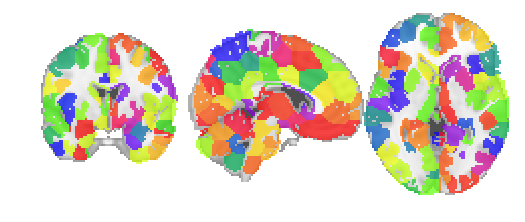

In [5]:
plotting.plot_roi(shen_atlas_filename, 
                  annotate = False, 
                  cut_coords = (5,0,0),
                  cmap = 'prism',
                  draw_cross = False, 
                  #title= 'Shen-268-node parcellation',
                 )
shen_masker = NiftiLabelsMasker(labels_img=shen_atlas_filename);
shen_masker.fit_transform(sample_file);

### compute static ISC

In [6]:
'''# Phase randomization (takes a couple minutes)
D = ts_data[:,:,:] # can reduce to [:,:,:40] to speed up computation...
print('Calculating ISC on ', D.shape[1], ' voxels/regions and ', D.shape[2], ' subjects')
ISC, p, distribution = camcan_phaseshift_isc(D, 
                                           #pairwise=True, #can use pairwise or ind2group
                                           summary_statistic=np.mean,
                                           n_shifts = 250, #can reduce to speed up, better increase to 1000
                                           return_distribution=True)
ISC[np.isnan(ISC)] = 0

alpha = .05
# Get q-values (i.e., FDR-controlled p-values) using statsmodels
q = multipletests(p[0, :], method='fdr_by')[1]
corrected = q[np.newaxis, :] < alpha
ISC[corrected == False] = 0

isc_result_dict = {}
isc_result_dict['ISC']          = ISC
isc_result_dict['p']            = p
isc_result_dict['distribution'] = distribution

#np.save('../data/isc_result_dict.npy', isc_result_dict) '''

print('load precomputed data - uncomment if you want to rerun ...')

isc_result_dict = np.load('../data/isc_result_dict.npy').item()
ISC = isc_result_dict['ISC'] 

load precomputed data - uncomment if you want to rerun ...


### map static ISC results back into brain-space and plot

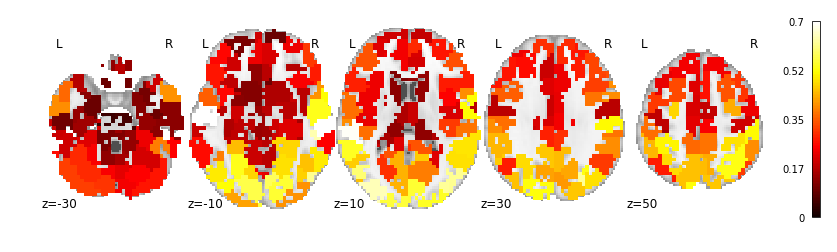

In [7]:
f = plt.figure(figsize=(14,4));
ax1 = f.add_subplot(111)

res_img = shen_masker.inverse_transform(ISC);
nilearn.plotting.plot_stat_map(nilearn.image.index_img(res_img,0), 
                               threshold = 0.0, 
                               vmax = 0.7, 
                               draw_cross = True,
                               display_mode = 'z',
                               cut_coords = [-30, -10, 10,  30,  50],
                               annotate = True,
                               #title = "static ISC results (corrected)",
                               axes = ax1);

### create result table of ISC by regions 

examine top-aligned and least-aligned regions

In [8]:
names_list = []
shen_dictionary = np.load(shen_dictionary_file).item()
for i in range(1,269):
     names_list.append(shen_dictionary[i]['name']) 
        
df = pd.DataFrame(names_list, columns =['RegionNr/Name'])
df['ISC'] = ISC.T

print(df.sort_values('ISC', ascending = False).head());
print(df.sort_values('ISC', ascending = False).tail());

                                         RegionNr/Name       ISC
196  30.25% Middle_Temporal_Gyrus_posterior_divisio...  0.727239
62   48.90% Middle_Temporal_Gyrus_posterior_divisio...  0.704245
190  48.08% Superior_Temporal_Gyrus_posterior_divis...  0.691004
203  46.71% Lateral_Occipital_Cortex_superior_divis...  0.645912
53   44.25% Middle_Temporal_Gyrus_posterior_divisio...  0.643404
          RegionNr/Name       ISC
130  100.00% Brain-Stem  0.071758
129   99.10% Brain-Stem  0.063452
265  100.00% Brain-Stem  0.055385
128  100.00% Brain-Stem  0.052737
267  100.00% Brain-Stem  0.052677


### compute ISC in subgroups

To gauge the consistency of our results, we can also compute them for sub-groups of the larger sample, e.g. split by age and sex.

senior_females
Calculating ISC on  268  voxels/regions and  112  subjects


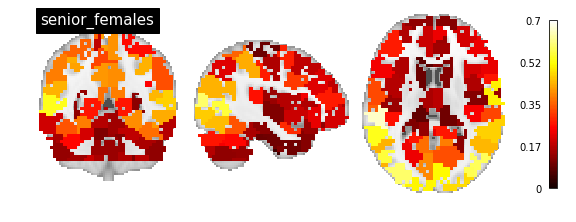

senior_males
Calculating ISC on  268  voxels/regions and  124  subjects


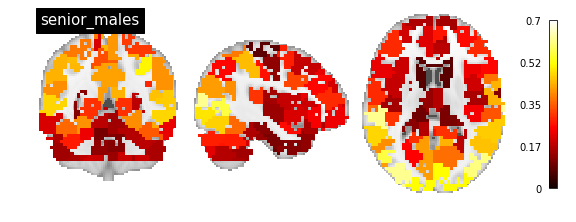

young_females
Calculating ISC on  268  voxels/regions and  140  subjects


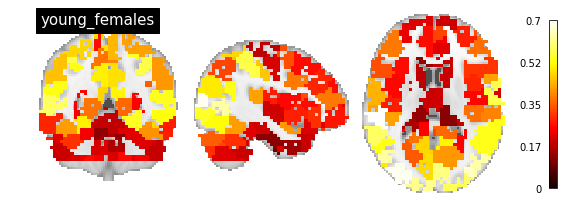

young_males
Calculating ISC on  268  voxels/regions and  118  subjects


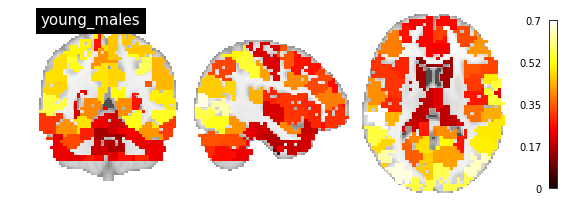

In [9]:
# create four groups
title_list = ['senior_females',
              'senior_males',
              'young_females',
              'young_males']

senior_females = np.intersect1d(np.where((gender_data == 2)), 
                  np.where(age_data > np.mean(age_data)), 
                  assume_unique=False)

senior_males = np.intersect1d(np.where((gender_data == 1)), 
                  np.where(age_data > np.mean(age_data)), 
                  assume_unique=False)

young_females = np.intersect1d(np.where((gender_data == 2)), 
                  np.where(age_data < np.mean(age_data)), 
                  assume_unique=False)

young_males = np.intersect1d(np.where((gender_data == 1)), 
                  np.where(age_data < np.mean(age_data)), 
                  assume_unique=False)

cond_list = [senior_females, senior_males, young_females, young_males]

# compute ISC and plot
subgroup_isc = []
for curr in range(len(cond_list)):
    curr_subs = cond_list[curr]
    D = ts_data[:,:,curr_subs]
    print(title_list[curr])
    print('Calculating ISC on ', D.shape[1], ' voxels/regions and ', D.shape[2], ' subjects')
    ISC = camcan_isc(D, summary_statistic=np.mean, verbose = False)
    ISC[np.isnan(ISC)] = 0
    isc_img = shen_masker.inverse_transform(ISC);
    nilearn.plotting.plot_stat_map(nilearn.image.index_img(isc_img,0), 
                                   threshold = 0.0, 
                                   vmax = 0.7, 
                                   draw_cross = False,
                                   cut_coords = (-40,-50,10),
                                   annotate = False,
                                   title = title_list[curr]);
    plt.show()
    subgroup_isc.append(ISC)

### assess spatial similarity across subgroups

In [10]:
subgroup_isc = np.squeeze(np.asarray(subgroup_isc))
subgroup_correlation_matrix = np.corrcoef(subgroup_isc)
np.tril_indices_from(subgroup_correlation_matrix, k=1)
np.mean(subgroup_correlation_matrix[np.tril_indices_from(subgroup_correlation_matrix, k=-1) ])

0.9776976762312489

### plot time series from one example region

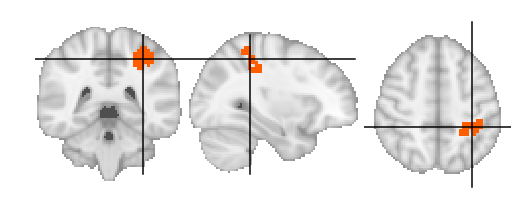

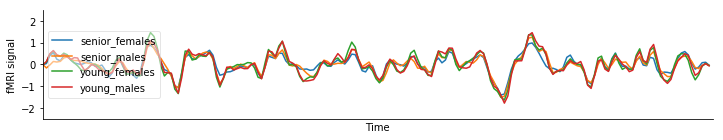

In [11]:
curr_region = 37 # 37/38 (SPL/postcentral)
shen_dictionary = np.load(shen_dictionary_file).item()
curr_title = shen_dictionary[curr_region + 1]['name'] 
curr_coords = shen_dictionary[curr_region + 1]['coords'] 

region_vector = np.zeros((1,268))
region_vector[0,curr_region] = 0.5
region_img = shen_masker.inverse_transform(region_vector);
nilearn.plotting.plot_stat_map(nilearn.image.index_img(region_img,0), 
                                   threshold = 0.4, 
                                   vmax = 1., 
                                   draw_cross = True,
                                   colorbar = False,
                                   annotate = False,
                                   cut_coords = curr_coords);
plt.show()

# plot time courses from the subgroups for this region
plt.figure(figsize = (12,2))
for curr in range(4):
    curr_subs = cond_list[curr]
    plt.plot( np.mean(ts_data[:,curr_region,curr_subs].T, axis = 0) , label = title_list[curr]);
plt.legend(loc = 6, fancybox=True, framealpha=0.5);
plt.xlabel('Time');
plt.ylabel('fMRI signal');
plt.xlim(0, 193);
plt.ylim(-2.5, 2.5)
plt.xticks([]);
sns.despine()